# Custom Problem Configuration

This notebook shows how to use the Job Shop Scheduling Environment to solve a custom defined JSP problem variant. It build upon a json based format for formulating a problem at hand, and uses the included parser to configure the JobShopEnv based on the provided data. One can then provide the envoronment to one of the included solution methods to solve the problem at hand. 

One can choose to formulate the following:

- Job shop or a Flow Shop problem
- Flexible Machine allocation (an operation can be processed on one or more machines)
- Assembly scheduling (an operation depends on multiple predecessors from different jobs to be complete to be started)
- Sequence dependent setup times (different setup times between different operations on the different machines)

Lets start with loading in the required imports:

In [1]:
from data.data_parsers.custom_instance_parser import parse
from visualization import gantt_chart, precedence_chart

from solution_methods.GA.src.initialization import initialize_run
from solution_methods.GA.run_GA import run_GA
from solution_methods.CP_SAT.run_cp_sat import run_CP_SAT

### Defining Custom Instance

We will solve a custom-defined problem instance, which we formulate in a JSON-based structure. For this, we define the nr of machines, the jobs (with their operations, processing times of operations on individual machines, and predecessor operation(s)), and the sequence-dependent setup times (configured between individual operations on the provided machines). 

Note: We recommend providing a new job_id to an operation that has multiple preceding operations.

In [2]:
processing_info = {
        "instance_name": "custom_problem_instance",
        "nr_machines": 2, 
        "jobs": [
            {"job_id": 0, "operations": [
                {"operation_id": 0, "processing_times": {"machine_1": 10, "machine_2": 20}, "predecessors": None},
                {"operation_id": 1, "processing_times": {"machine_1": 25, "machine_2": 19}, "predecessors": [0]}
            ]},
            {"job_id": 1, "operations": [
                {"operation_id": 2, "processing_times": {"machine_1": 23, "machine_2": 21}, "predecessors": None},
                {"operation_id": 3, "processing_times": {"machine_1": 12, "machine_2": 24}, "predecessors": [2]}
            ]},
            {"job_id": 2, "operations": [
                {"operation_id": 4, "processing_times": {"machine_1": 37, "machine_2": 21}, "predecessors": None},
                {"operation_id": 5, "processing_times": {"machine_1": 23, "machine_2": 34}, "predecessors": [4]}
            ]}
        ],
        "sequence_dependent_setup_times": {
            "machine_1": [
                [0, 25, 30, 35, 40, 45],
                [25, 0, 20, 30, 40, 50],
                [30, 20, 0, 10, 15, 25],
                [35, 30, 10, 0, 5, 10],
                [40, 40, 15, 5, 0, 20],
                [45, 50, 25, 10, 20, 0]
            ],
            "machine_2": [
                [0, 21, 30, 35, 40, 45],
                [21, 0, 10, 25, 30, 40],
                [30, 10, 0, 5, 15, 25],
                [35, 25, 5, 0, 10, 20],
                [40, 30, 15, 10, 0, 25],
                [45, 40, 25, 20, 25, 0]
            ]
        }
    }

### Intrepretting configured Instances

By plotting the different jobs, operations and their precedence constratints, we can inspect wether the configred job:

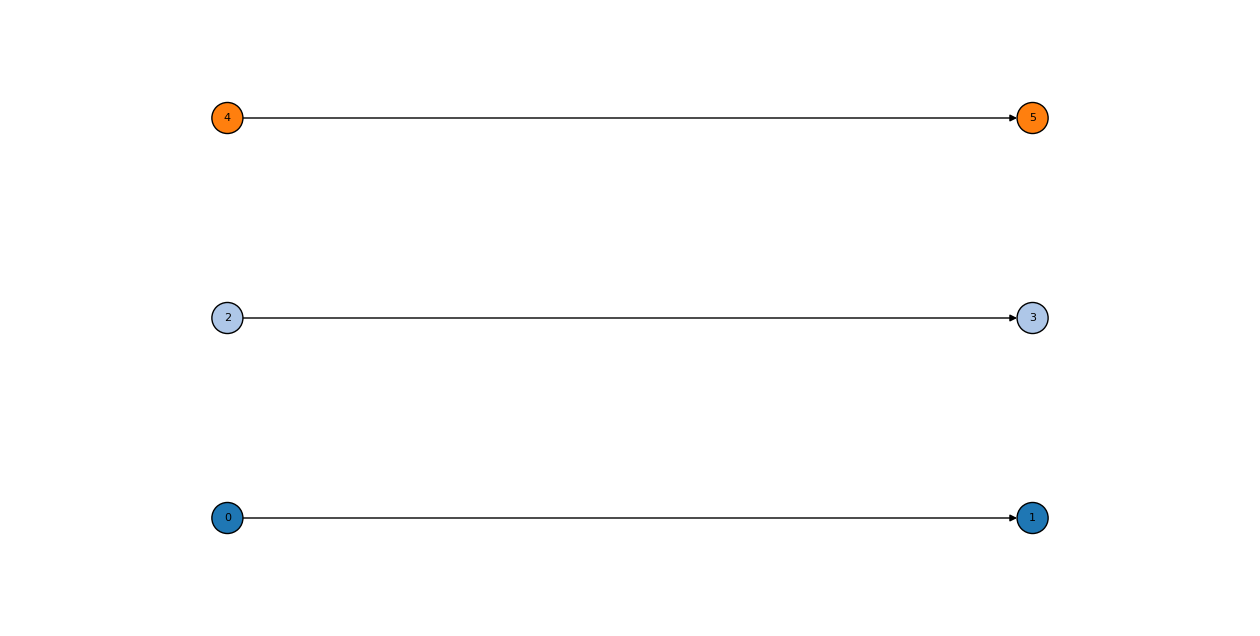

In [3]:
jobShopEnv = parse(processing_info)
precedence_chart.plot(jobShopEnv)

### CP-SAT solver

In the code below we configure the OR-TOOLS CP-SAT solver to solve the defined problem. For this, we decide one the time limit for the solver (in seconds) and what model to use (current implementations allows for: jsp, fsp, fjsp and fjsp_sdst).

Solution 0, time = 0.012735 s, objective = 102
Solution 1, time = 0.017049 s, objective = 100
Solution:
Optimal Schedule Length: 100.0


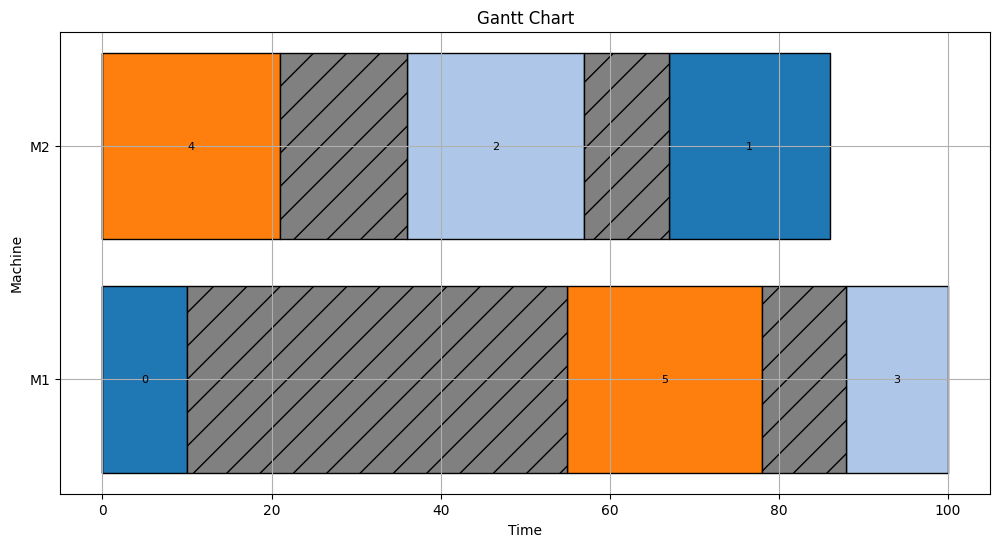

In [4]:
parameters = {"instance": {"problem_instance": "custom_problem_instance"},
             "solver": {"time_limit": 3600, "model": "fjsp_sdst"},
             "output": {"logbook": True}
             }

jobShopEnv = parse(processing_info)
results, jobShopEnv = run_CP_SAT(jobShopEnv, **parameters)

plt = gantt_chart.plot(jobShopEnv)
plt.show()

### Genetic Algorithm

In the code below we configure the Genetic Algorithm (GA) to solve the defined problem. For this, we decide on the population size, number of search generations (ngen), crossover rate (cr), and mutation probability (input). We also specify 'multiprocessing' as true to allow for parallel evaluation of the different obtained solutions in the different generations of the search.

INFO:root:gen	avg    	std          	min   	max   
0  	[142.9]	[21.91551962]	[116.]	[188.]
INFO:root:
INFO:root:1  	[136.4]	[15.34405422]	[119.]	[167.]
INFO:root:2  	[121.8]	[5.32541078] 	[118.]	[133.]
INFO:root:3  	[118.9]	[8.01810451] 	[100.]	[133.]
INFO:root:4  	[116.1]	[9.15914843] 	[100.]	[133.]
INFO:root:5  	[106.6]	[6.26418391] 	[100.]	[118.]
INFO:root:6  	[101.8]	[2.74954542] 	[100.]	[106.]
INFO:root:7  	[100.] 	[0.]         	[100.]	[100.]
INFO:root:8  	[100.] 	[0.]         	[100.]	[100.]
INFO:root:9  	[103.5]	[10.5]       	[100.]	[135.]
INFO:root:10 	[109.5]	[28.5]       	[100.]	[195.]
INFO:root:Makespan: 100


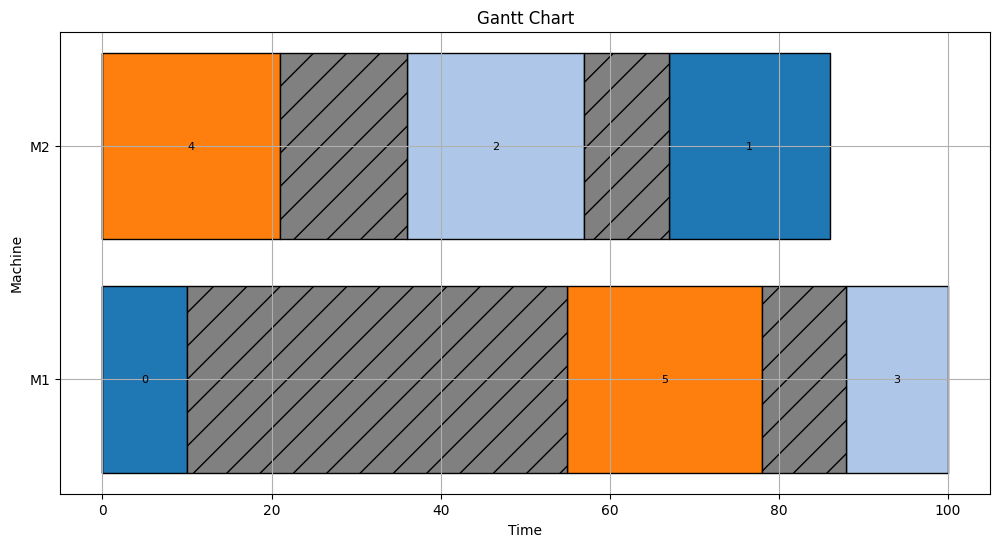

In [5]:
parameters = {"instance": {"problem_instance": "custom_problem_instance"},
             "algorithm": {"population_size": 10, "ngen": 10, "seed": 5, "cr": 0.7, "indpb": 0.2, 'multiprocessing': True},
             "output": {"logbook": True}
             }

jobShopEnv = parse(processing_info)
population, toolbox, stats, hof = initialize_run(jobShopEnv, **parameters)
makespan, jobShopEnv = run_GA(jobShopEnv, population, toolbox, stats, hof, **parameters)

plt = gantt_chart.plot(jobShopEnv)
plt.show()